# Choosing wavelets for CWT

Work in progress

To figure out for this notebook:
* About the wavelet familiies
* About how you choose
* Explaining more info about morlet wavelets and complex wavelets and what that all means
* Further understanding of scaleograms and how to interpret them

## Set-up

In [1]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
from scipy import signal

In [2]:
def clean_fhr(fhr, show_figure=False):
    '''
    Cleans fetal heart rate (FHR) signal.
    Inputs:
    fhr - series, the "FHR" column from one of the csv files
    show_figure - boolean, whether to display the FHR before and after cleaning
    Outputs:
    fhr - series, clean version of the FHR column
    '''
    if show_figure:
        # Show original trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    # Replace 0 with NaN
    fhr.replace(0, np.nan, inplace=True)

    # Remove NaN if they occured for more than 15 seconds consecutively
    na = fhr.isnull()
    fhr = fhr[~(fhr.groupby(na.ne(na.shift()).cumsum().values).transform('size').ge(16) & na)].reset_index(drop=True)

    # Set outliers to NaN
    fhr[fhr < 50] = np.nan
    fhr[fhr > 200] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Find how each value has changed from the prior value
    diff = fhr - fhr.shift()

    # Where difference is more than +- 25, set as NaN
    fhr[(diff > 25) | (diff < -25)] = np.nan

    # Replace missing values using linear interpolation
    fhr = fhr.interpolate(method='linear')

    # Clip to last 90 minutes
    fhr = fhr.tail(90*60)

    if show_figure:
        # Show clean trace
        fhr.plot(figsize=(15, 5))
        plt.show()

    return(fhr)

In [3]:
# Import example of a FHR and UCR to be used in notebook, cleaning FHR
ctg = pd.read_csv('data_csv/1001.csv')
fhr = clean_fhr(ctg['FHR'])
uc = ctg['UC']

## Wavelet families

Wavelets are organised into families, with some best for DWT and CWT. In the package `pywt`, the continuous wavelets available are displayed below.

In [4]:
continuous_wavelets = pywt.wavelist(kind='continuous')

/home/amy/miniconda3/envs/ctg/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_28994/2084915622.py:3: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet_function, x_values = pywt.ContinuousWavelet(wavelet).wavefun()
/tmp/ipykernel_28994/2084915622.py:3: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet_function, x_values = pywt.ContinuousWavelet(wavelet).wavefun()
/tmp/ipykernel_28994/2084915622.py

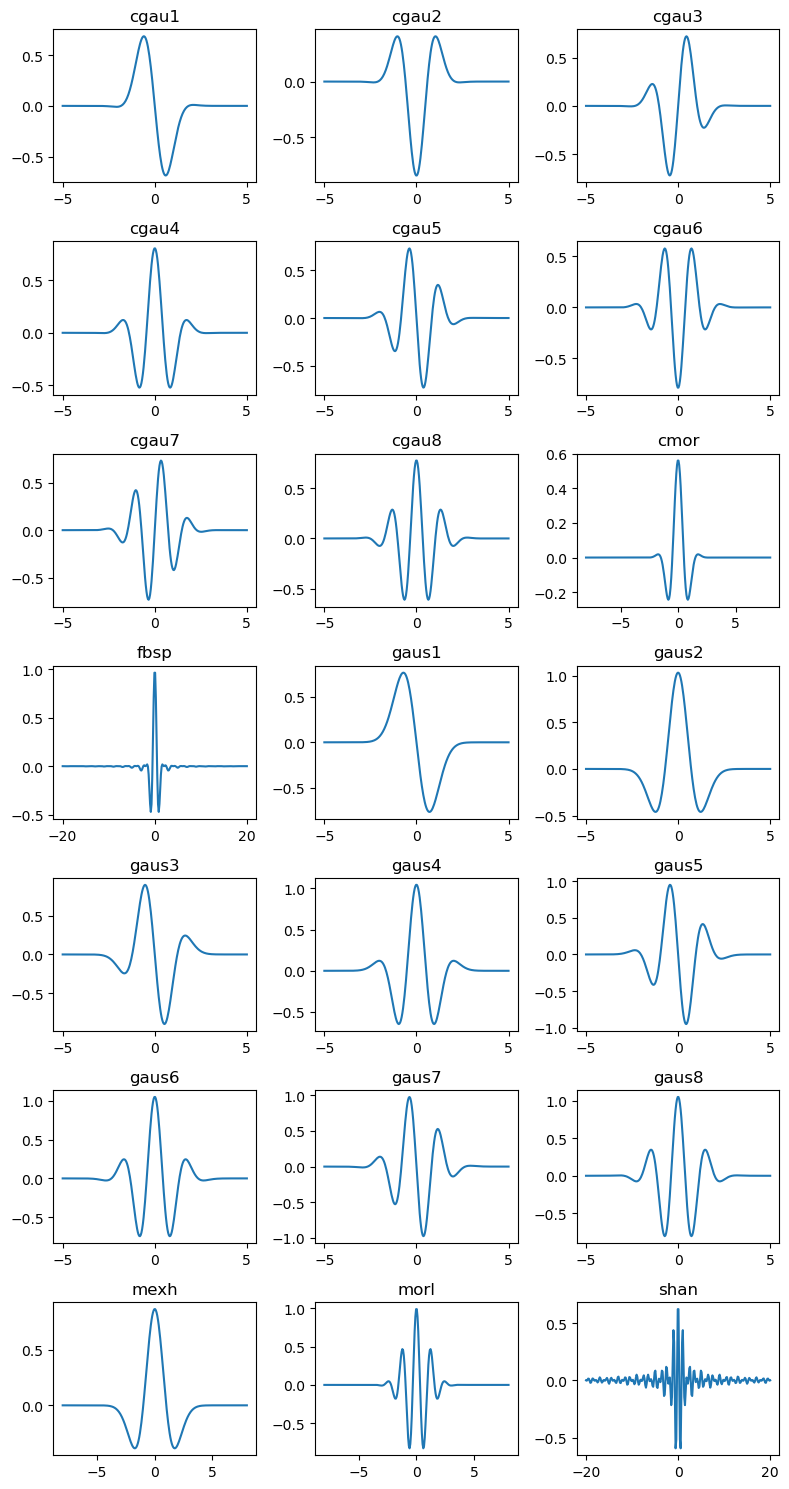

In [5]:
fig, ax = plt.subplots(nrows=7, ncols=3, figsize=(8, 15))
for wavelet, ax in zip(continuous_wavelets, ax.ravel()):
    wavelet_function, x_values = pywt.ContinuousWavelet(wavelet).wavefun()
    ax.plot(x_values, wavelet_function)
    ax.set_title(wavelet)
plt.tight_layout()
plt.show()

## Morlet Wavelets

Versions of the Morlet wavelet:
* Real-valued version - sometimes referred to as "real Morlet" or just "Morlet wavelet"
* Complex version - sometimes referred to as "complex Morlet" or "Gabor wavelet"

Rough notes:
* A Morlet wavelet is a sine wave tapered by a Gaussian. A complex Morlet wavelet is a complex-valued sine wave tapered by a real-valued Gaussian.[[source]](https://www.sciencedirect.com/science/article/pii/S1053811919304409)
* Why is there a complex version?Due to limitations of real wavelet: Oscillation, Shift variance, Aliasing[[source]](https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=924D894AEBCA3A939CC1297FF28B1BA4?doi=10.1.1.695.137&rep=rep1&type=pdf)
* Complex-valued wavelets are useful in cases where you want to analyze phase as well as magnitude.[[source]](https://uk.mathworks.com/matlabcentral/answers/76072-what-is-the-difference-between-the-complex-morlet-waveform-and-the-morlet-wavelet-transformation-cw)

In [6]:
print(pywt.ContinuousWavelet('morl'))

ContinuousWavelet morl
  Family name:    Morlet wavelet
  Short name:     morl
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False


Morlet wavelet is a complex wavelet - it has real and imaginary dimensions as it incorporates complex numbers (numbers with real and imaginary parts).

**Real number** = includes negative and positive: integers, decimals and fractional numbers

**Imaginary number** = square root of negative number (as you can't - all numbers squared become positive) - can think of as $\sqrt{-1}$ multiplied by a real number with examples like:
* $\sqrt{-1}$ (i.e. i) * $\sqrt{4}$ (i.e. 2) = 2i
* $\sqrt{-1}$ (i.e. i) * $\sqrt{3}$ (can't simplify) = i $\sqrt{3}$

**Complex number** = sum of real number and imaginary number

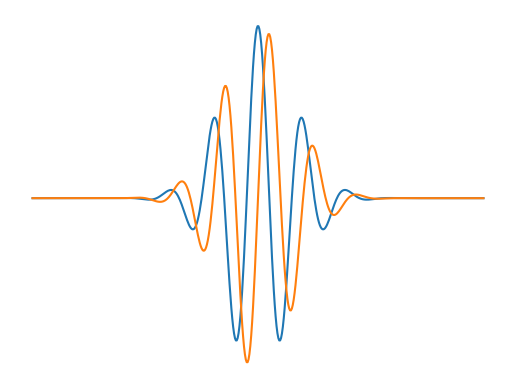

In [7]:
# Source: https://neurodsp-tools.github.io/neurodsp/auto_tutorials/timefreq/plot_MorletWavelet.html


# Define the sampling rate/frequency, fundamental frequency, and number of
# cycles per frequency (or omega), and the scale factor
fs = 500
freq = 5
n_cycles = 5

# Calculate wavelet length (e.g. 5 * (500/5) = 500)
wavelet_len = int(n_cycles * fs / freq)

# Plot both real and imaginary dimensions of the wavelet
_, ax = plt.subplots()
ax.plot(np.real(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax.plot(np.imag(signal.morlet(M=wavelet_len, w=n_cycles, s=1)))
ax.set_axis_off()

## Ricker wavelet

Also known as the "Mexican hat wavelet".

## CWT using different wavelets on the same signal

Demonstrate differences similar to https://www.hindawi.com/journals/ijhy/2021/9938584/fig1/ - having signal, wavelet and scaleogram

In [8]:
def cwt_plot(wavelet, axes):
    '''
    Perform CWT using scipy and the provided wavelet
    Then plot spectogram on provided axes
    Using widths 1 to 30
    '''
    # Perform CWT with Morlet and plot
    cwtmatr = signal.cwt(fhr, wavelet, np.arange(1, 31))

    # Plot the spectogram
    magn = np.absolute(cwtmatr)
    axes.imshow(magn,
                extent=[min(fhr.index), max(fhr.index), 1, 31],
                aspect='auto')
    axes.set_ylabel('Scale')

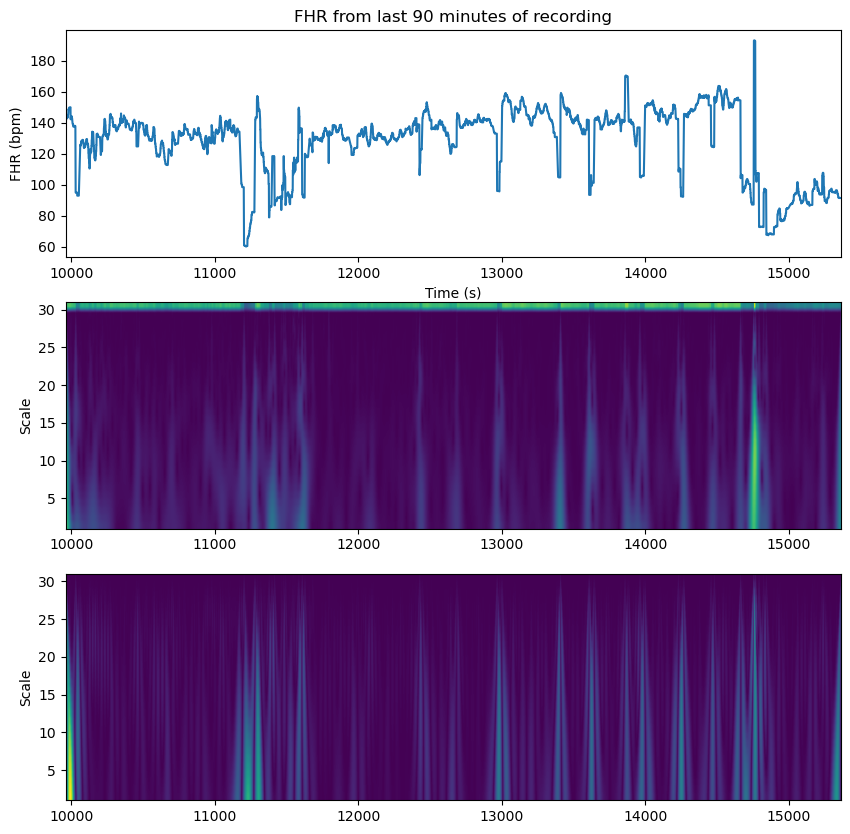

In [9]:
# Plot FHR
fig, axes = plt.subplots(nrows=3, figsize=(10, 10))
axes[0].plot(fhr)
axes[0].margins(x=0)
axes[0].set_title('FHR from last 90 minutes of recording')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('FHR (bpm)')

# CWT with different wavelets
cwt_plot(signal.morlet2, axes[1])
cwt_plot(signal.ricker, axes[2])

## Understanding scaleograms # 1

In [10]:
def scaleogram_example(sig, cmap):
    '''
    This is an example of how do to CWT and scaleogram from scipy
    Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cwt.html
    Inputs:
    sig - array that contains signal
    cmap - colourmap to use
    '''
    fig, ax = plt.subplots(nrows=2, figsize=(6, 4))

    # Plot provided signal
    ax[0].plot(sig)

    # Perform CWT and plot scaleogram
    widths = np.arange(1, 31)
    cwtmatr = signal.cwt(sig, signal.ricker, widths)
    cwtmatr_yflip = np.flipud(cwtmatr)
    im = ax[1].imshow(cwtmatr_yflip, extent=[-1, 1, 1, 31],
                      cmap=cmap, aspect='auto',
                      vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
    plt.colorbar(im, orientation='horizontal')
    plt.tight_layout()
    plt.show()

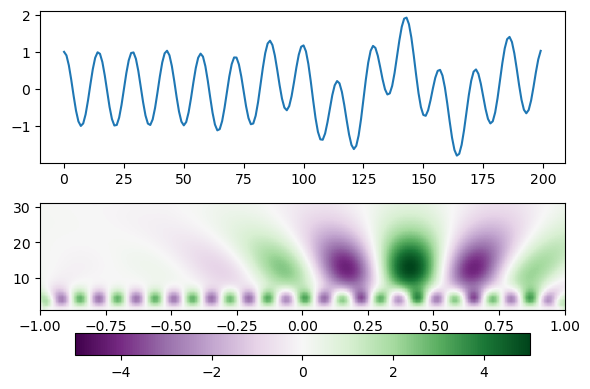

In [11]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
scaleogram_example(sig=sig, cmap='PRGn')

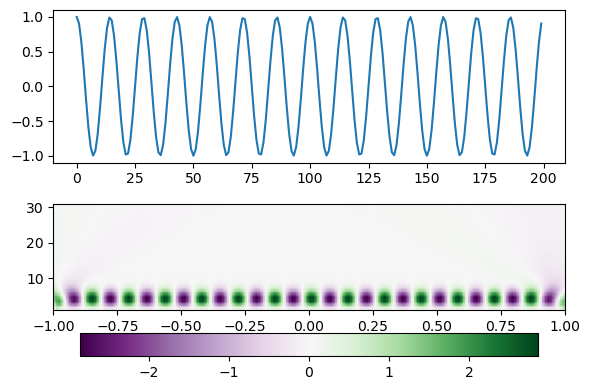

In [12]:
# Removing gausspulse
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t)
scaleogram_example(sig=sig, cmap='PRGn')

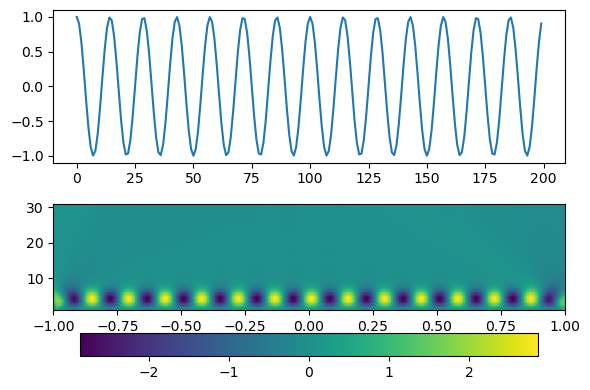

In [13]:
# Removing gausspulse and different colourmap
t = np.linspace(-1, 1, 200, endpoint=False)
sig = np.cos(2 * np.pi * 7 * t)
scaleogram_example(sig=sig, cmap='viridis')

**Confused**: Why is it different colours for peaks and troughs? Surely amplitude shouldn't mind about direction?

## Understanding scaleograms # 2

In [14]:
def cwt_plot(scale_max=151, sig=fhr):
    '''
    scale_max
    '''
    # Plot FHR
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
    ax[0].plot(sig)
    ax[0].margins(x=0)
    ax[0].set_title('FHR from last 90 minutes of CTG')
    ax[0].set_xlabel('Time (s)')
    ax[0].set_ylabel('FHR (bpm)')

    # Perform CWT
    cwtmatr = signal.cwt(sig, signal.morlet2, np.arange(1, scale_max))

    # Plot the magnitude
    magn = np.absolute(cwtmatr)
    print(magn.shape)
    im = ax[1].imshow(
        magn,
        extent=[min(sig.index), max(sig.index), 1, scale_max],
        aspect='auto',
    )
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Wavelet scale (inverse of frequency)')
    plt.colorbar(im, ax=ax[1], orientation='horizontal', aspect=8
)
    plt.show()

### Changing the max scale (i.e. looking to lower frequencies)

You can see that this removes the bar of colour from across of the chart - I'm presuming (but not certain) that this indicates that I previously wasn't looking at enough scales?

(30, 5400)


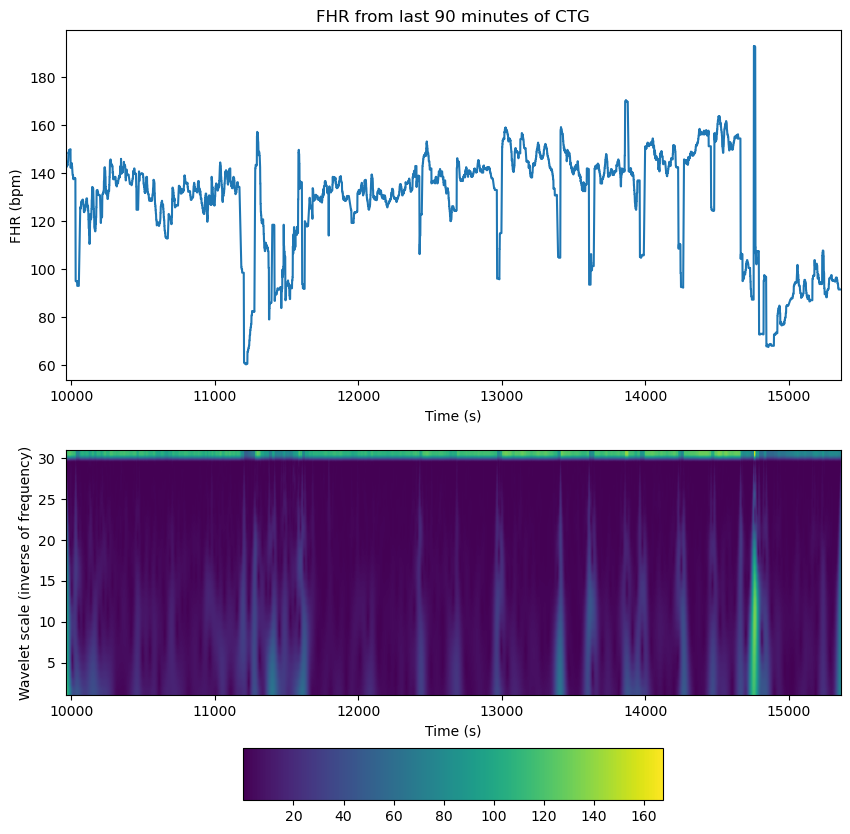

In [15]:
cwt_plot(scale_max=31)

(150, 5400)


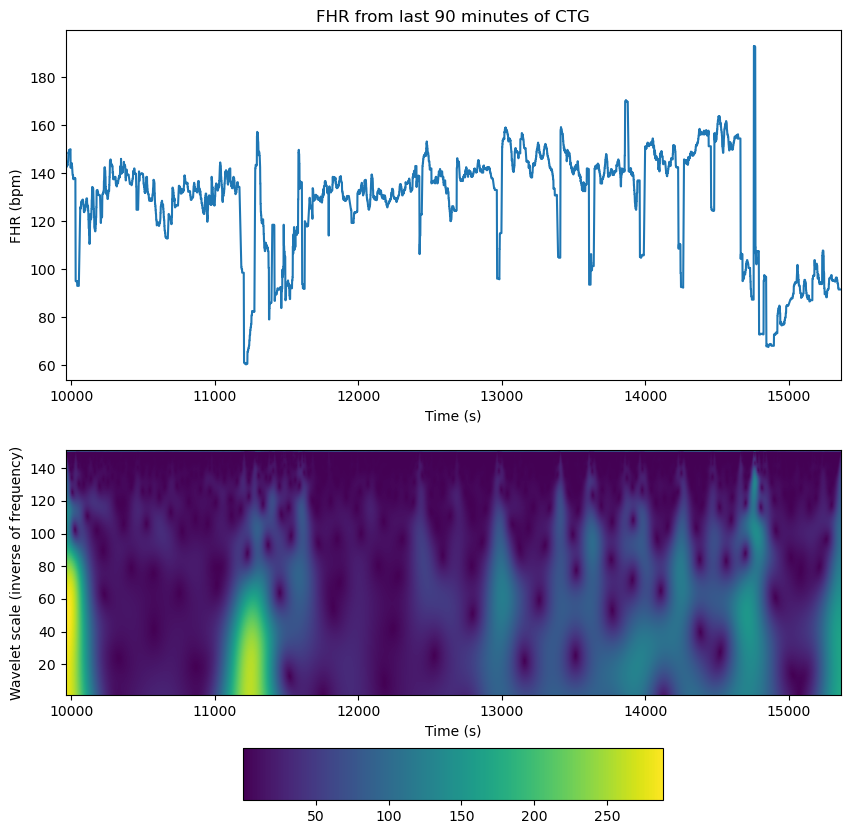

In [16]:
cwt_plot(scale_max=151)

### Changing the units of signal

You can see that shifting the signal by adding a constant changes the scaleogram visual, which I had not expected, as I thought it should only be about the shape of the signal and not about the y axis.

(150, 5400)


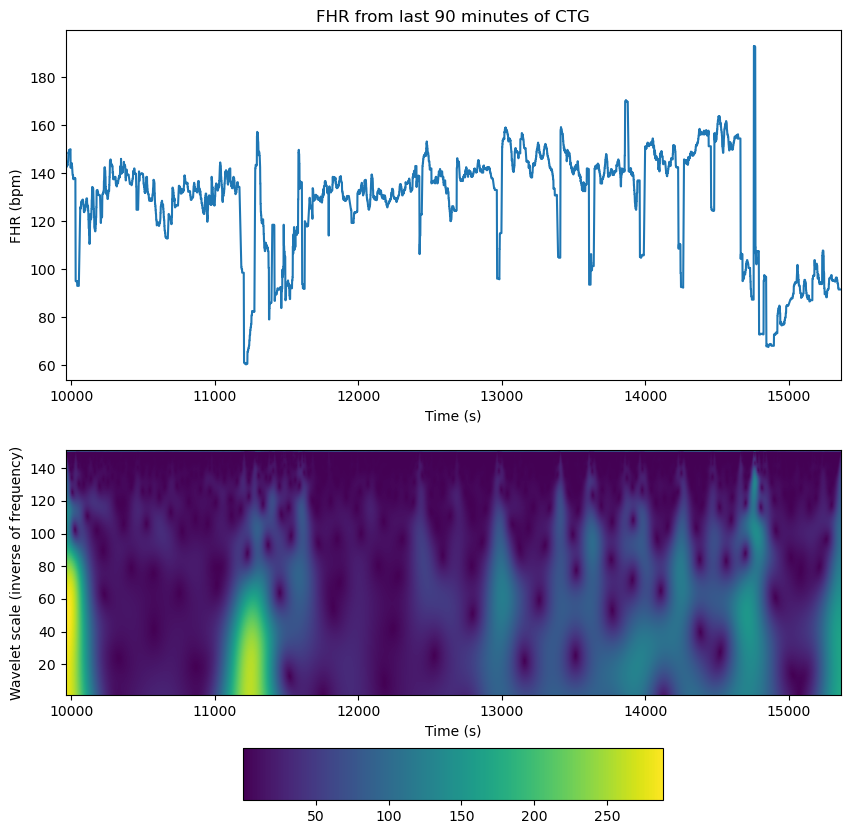

In [17]:
cwt_plot(sig=fhr)

(150, 5400)


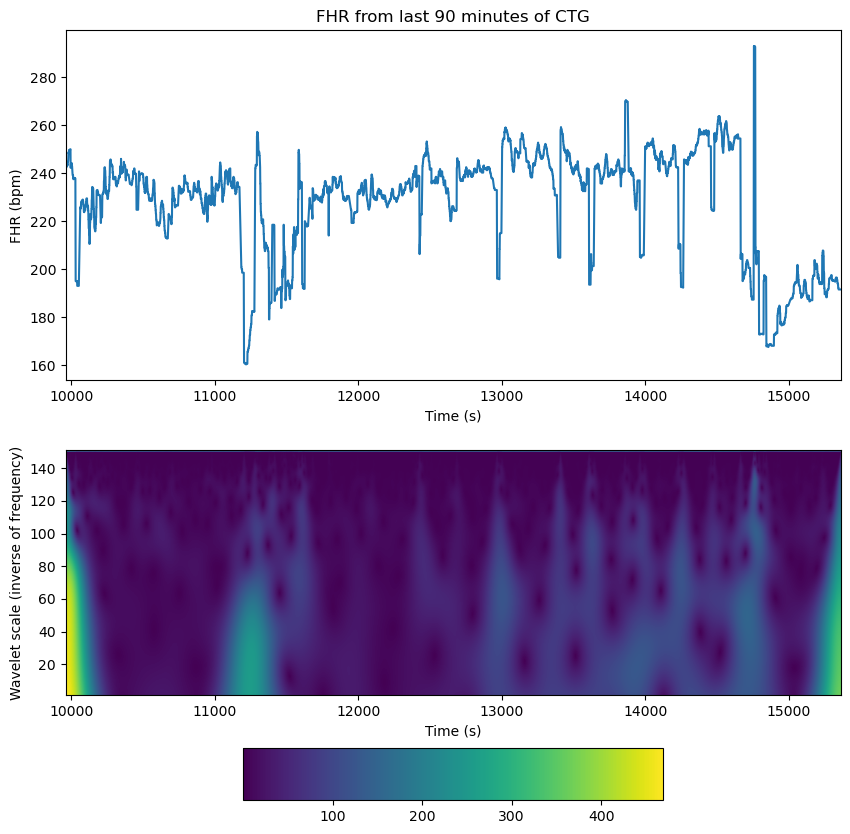

In [18]:
cwt_plot(sig=fhr+100)

(150, 5400)


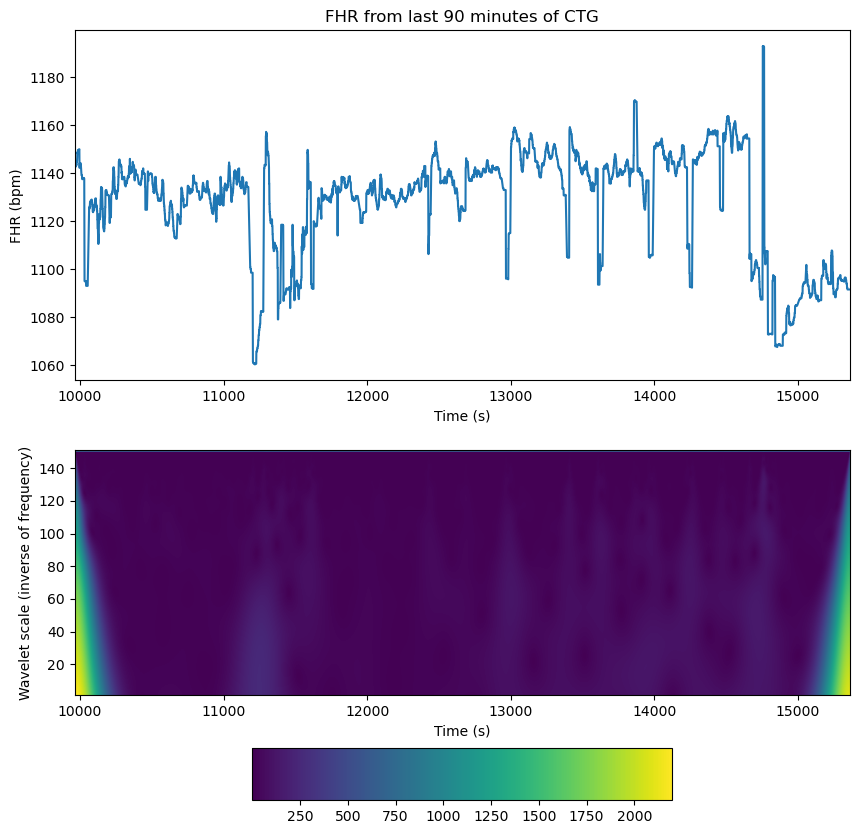

In [19]:
cwt_plot(sig=fhr+1000)

This result clearly shows what I think to be **edge-effect artifacts**. These are areas where "the stretched wavelets extend beyond the edges of the observation interval". You could draw a **cone of influence** which would be in the two bottom corners of the figure, and in those, you should be suspicious about edge effects and understand that these may not be an accurate time-frequency representation of the data. These are also referred to as **boundary effects**.[[source]](https://uk.mathworks.com/help/wavelet/ug/boundary-effects-and-the-cone-of-influence.html)

I'm not sure why this occurs when the units of the signal is changed but the shape of the signal itself remains the same.

### Normalised

It generally says you don't need to do pre-processing, but changing the units made me suspicious, so I also tried it scaled (mean 0, SD1), which mainly seemed to impact the edge colours?

(150, 5400)


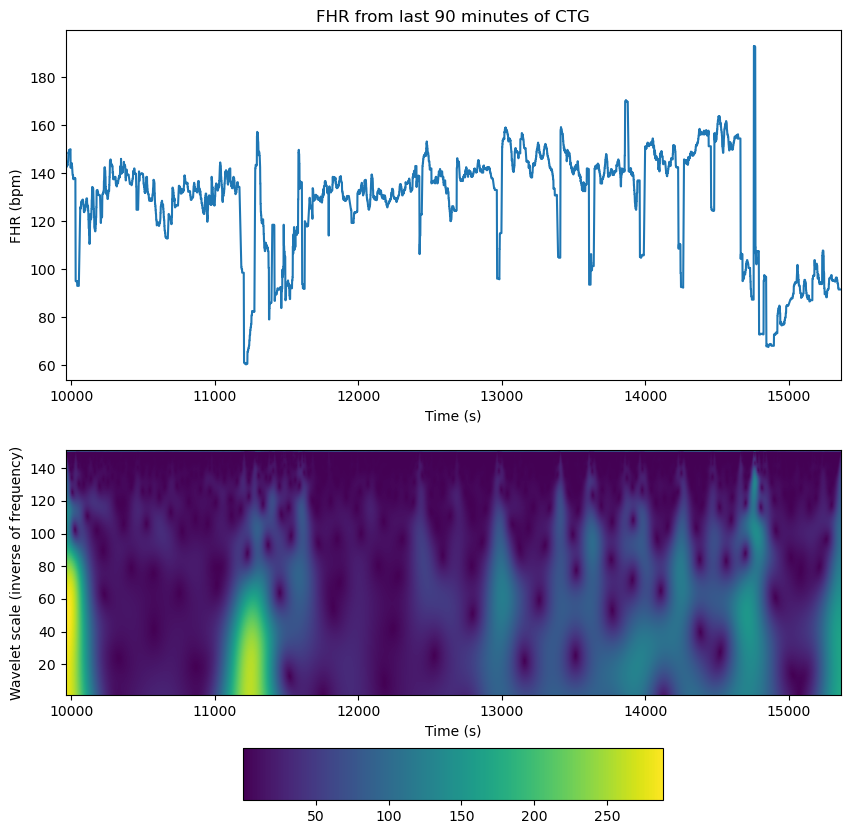

In [20]:
cwt_plot()

(150, 5400)


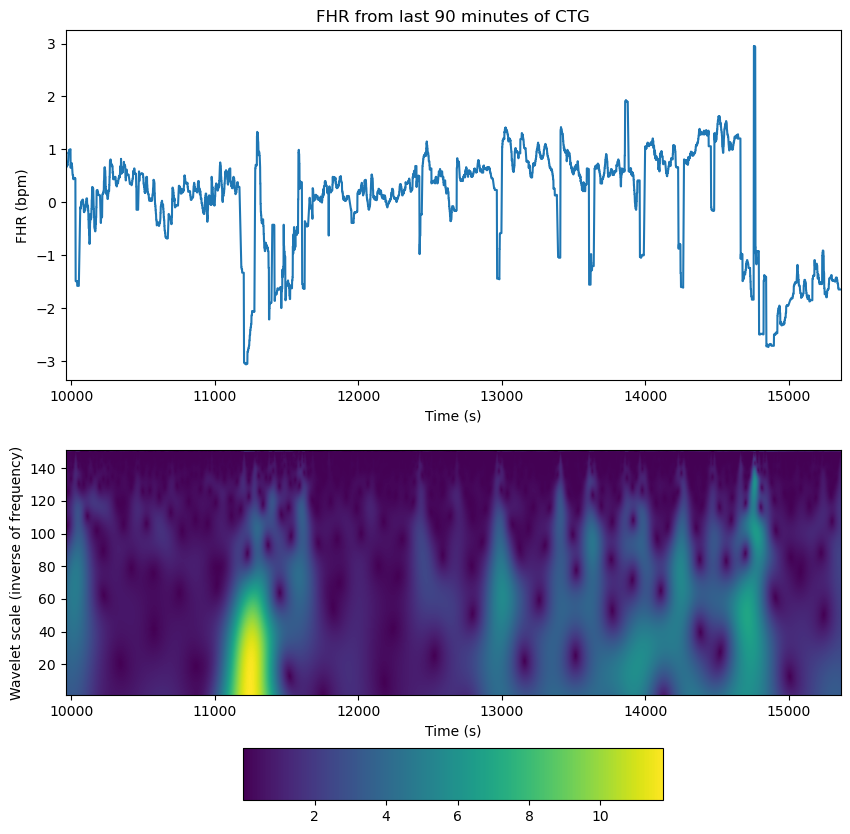

In [21]:
fhr_mean = fhr.mean()
fhr_sd = fhr.std()
fhr_norm = (fhr - fhr_mean) / fhr_sd
cwt_plot(sig=fhr_norm)

### Smoothing the signal

I tried different methods of smoothing to see how that impacted the results:
* DWT - this compresses the signal (so x axis is 175 rather than 5400) - and I think that has led to us losing the information as it doesn't seem to mean much
* Rolling average - doesn't look hugely different

(150, 5400)


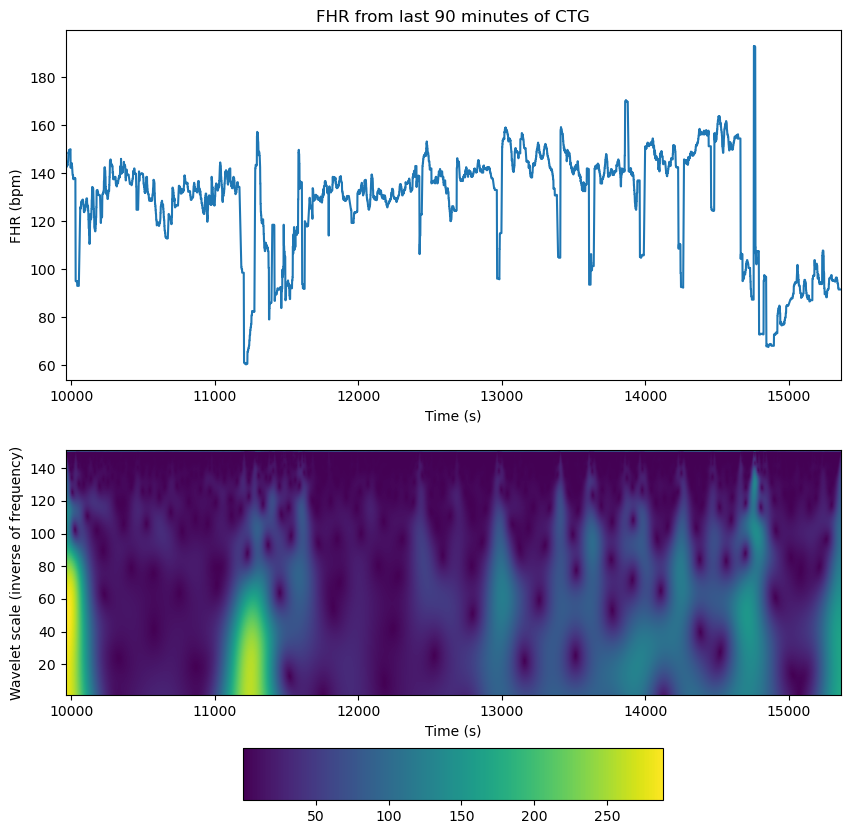

In [22]:
cwt_plot()

(150, 175)


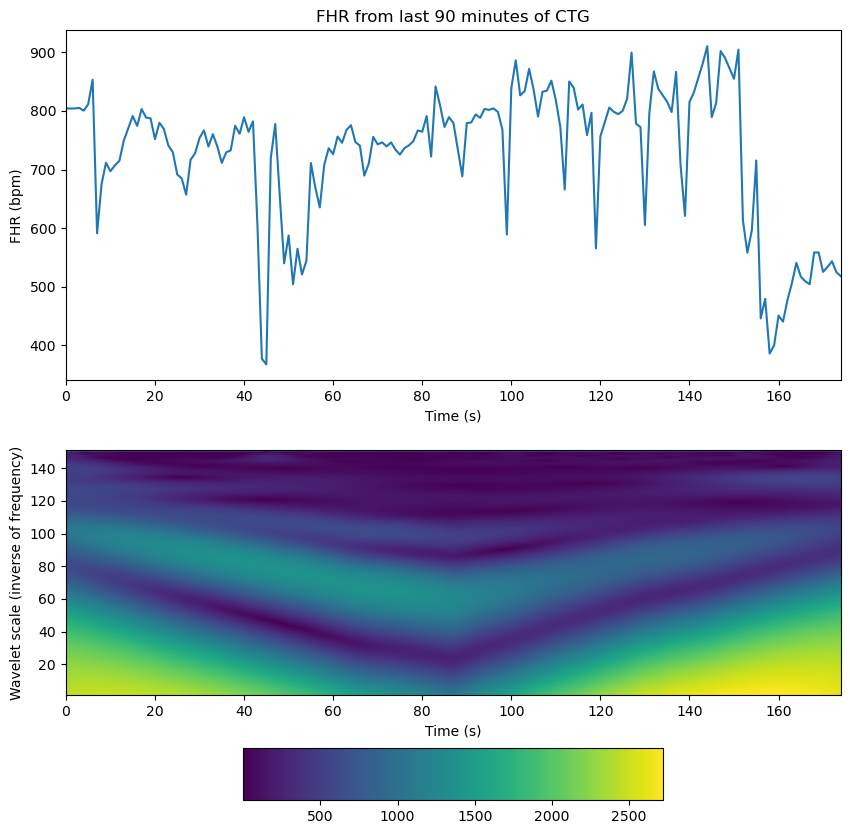

In [23]:
# Perform DWT and take first wavelet
wavelets = pywt.wavedec(fhr, 'db4', level=5)
dwt_fhr = wavelets[0]
cwt_plot(sig=pd.Series(dwt_fhr))

(150, 5341)


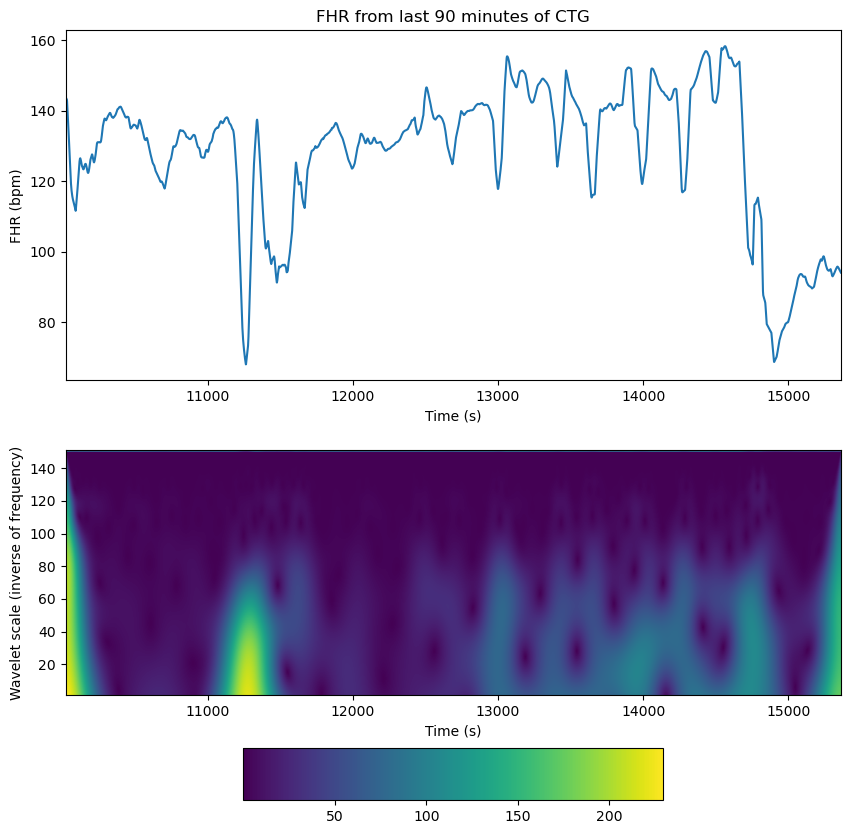

In [24]:
# Rolling mean
rolling = fhr.rolling(window=60).mean().dropna()

cwt_plot(sig=rolling)

## Other random notes to sort

PYWT

https://dsp.stackexchange.com/questions/70575/pywavelets-cwt-implementation

https://pastebin.com/y4Q4EgNB - run below...

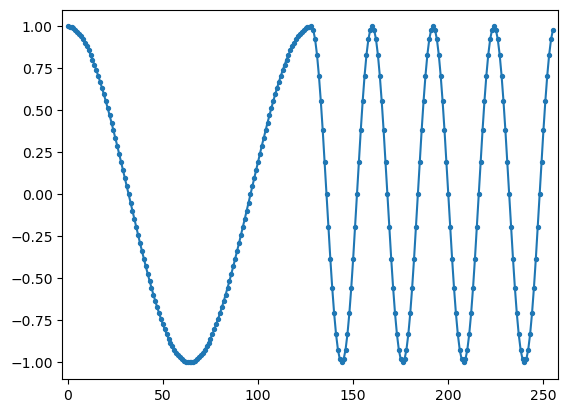

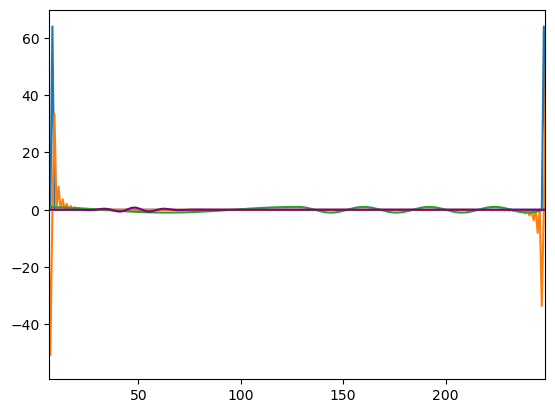

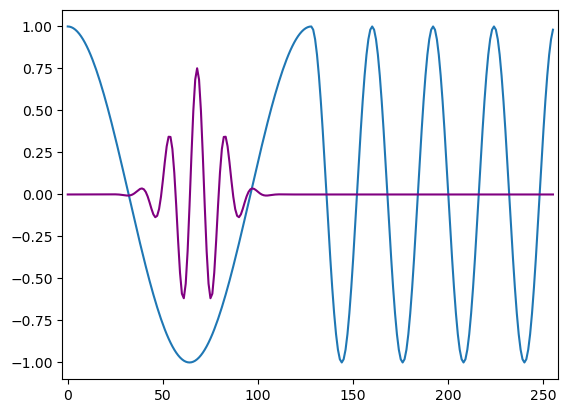

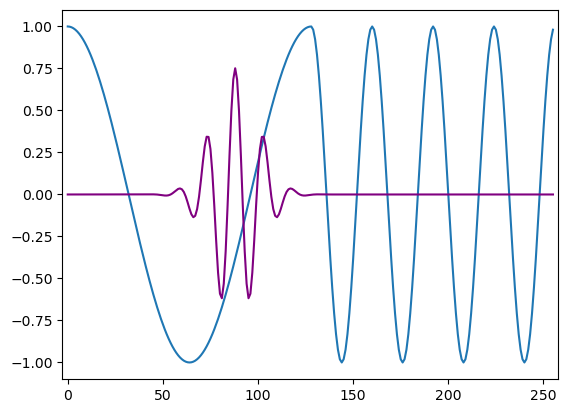

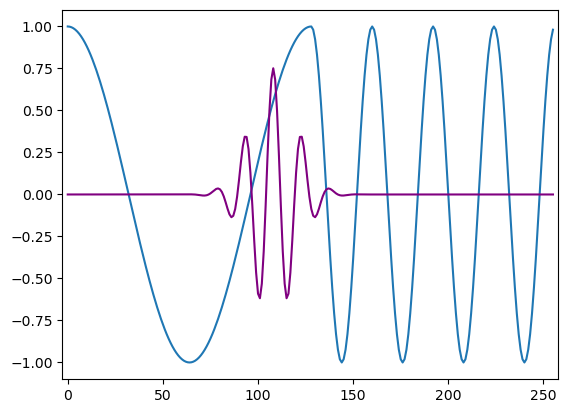

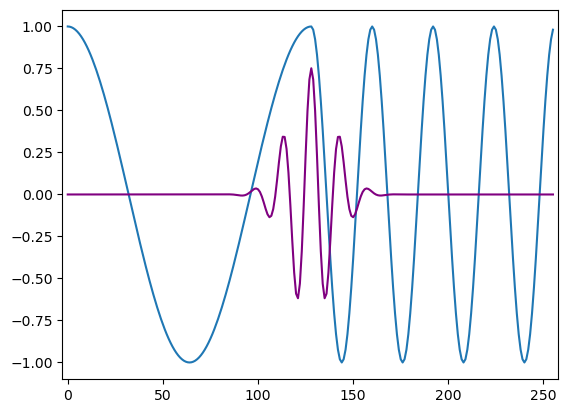

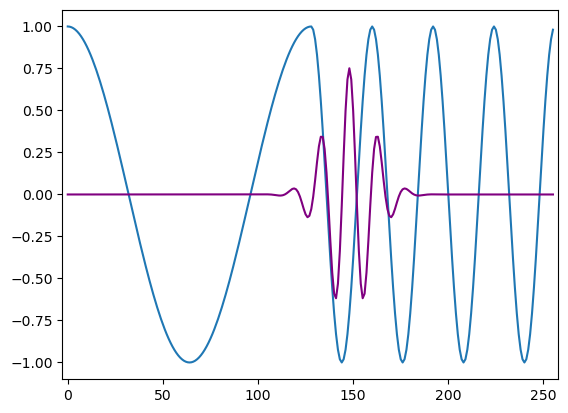

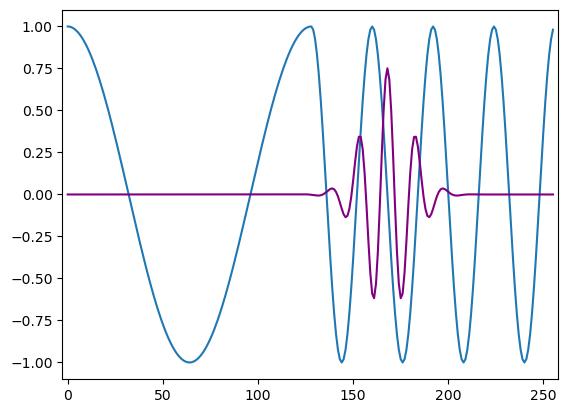

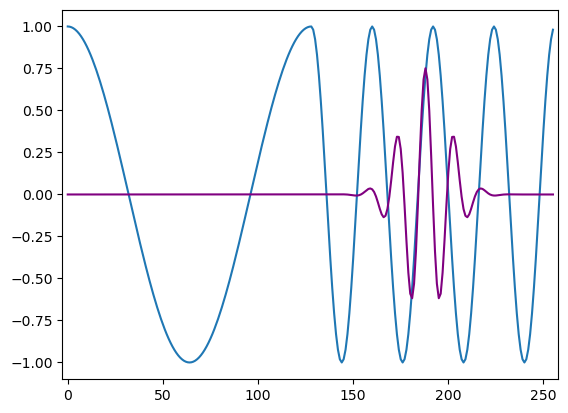

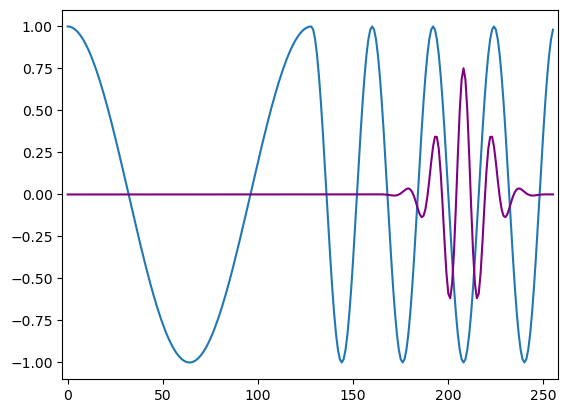

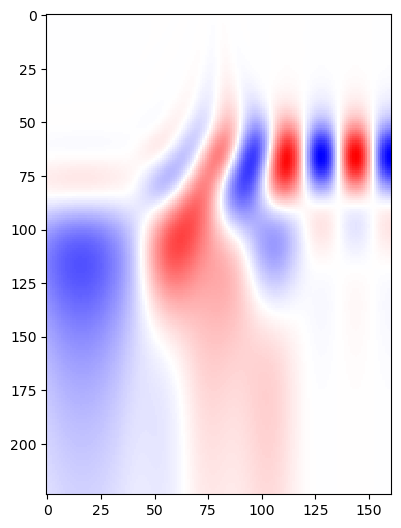

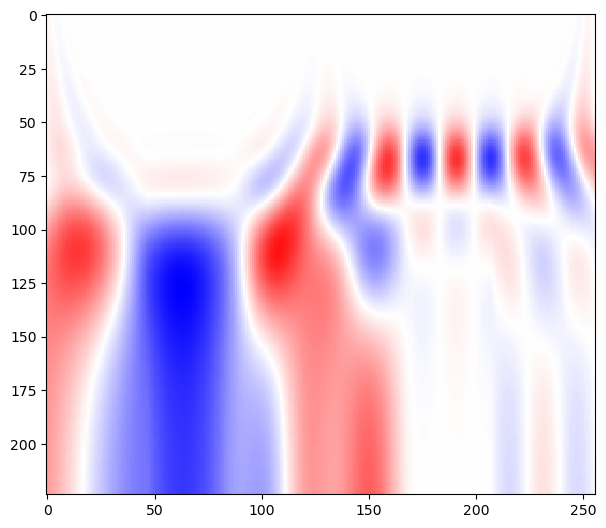

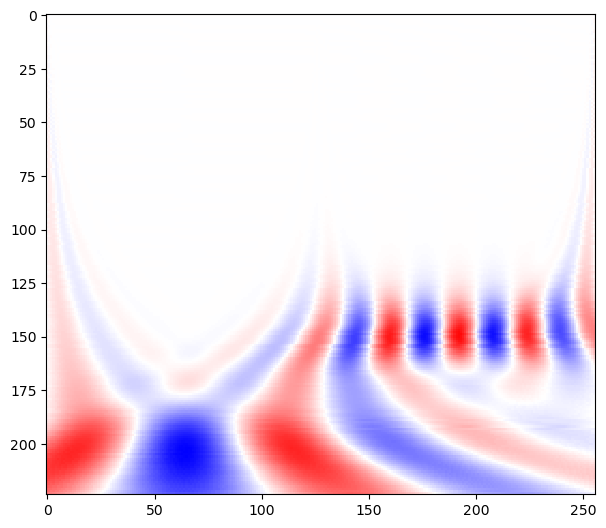

In [25]:
#%%###########################################################################
def allfft(x):
    coef = np.fft.fft(x)
    return coef, np.angle(coef), np.abs(coef)
 
def wplot(x, y=None, size=0, show=False, ax_equal=False, **kw):
    if y is None:
        plt.plot(x, **kw)
    else:
        plt.plot(x, y, **kw)
    _scale_plot(plt.gcf(), plt.gca(), size=size, show=show, ax_equal=ax_equal)
    
def wscat(x, y=None, size=0, show=False, ax_equal=False, s=18, **kw):
    if y is None:
        plt.scatter(np.arange(len(x)), x, s=s, **kw)
    else:
        plt.scatter(x, y, s=s, **kw)
    _scale_plot(plt.gcf(), plt.gca(), size=size, show=show, ax_equal=ax_equal)
 
def imshow(data, norm=None, complex=None, show=1, **kw):
    kw['interpolation'] = kw.get('interpolation', 'none')
    if norm is None:
        mx = np.max(np.abs(data))
        vmin, vmax = -mx, mx
    else:
        vmin, vmax = norm
 
    if (complex is None and np.sum(np.abs(np.imag(data))) < 1e-8) or (
            complex is False):
        plt.imshow(np.real(data), cmap='bwr', vmin=vmin, vmax=vmax, **kw)
    else:
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(data.real, cmap='bwr', vmin=vmin, vmax=vmax, **kw)
        axes[1].imshow(data.imag, cmap='bwr', vmin=vmin, vmax=vmax, **kw)
 
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
    if show:
        plt.show()
 
 
def _scale_plot(fig, ax, size=True, show=False, ax_equal=False):
    xmin, xmax = ax.get_xlim()
    rng = xmax - xmin
    ax.set_xlim(xmin + .018 * rng, xmax - .018 * rng)
    if size:
        fig.set_size_inches(15, 7)
    if ax_equal:
        yabsmax = max(np.abs([*ax.get_ylim()]))
        mx = max(yabsmax, max(np.abs([xmin, xmax])))
        ax.set_xlim(-mx, mx)
        ax.set_ylim(-mx, mx)
        fig.set_size_inches(8, 8)
    if show:
        plt.show()
#%%###########################################################################
def morlet(sigma=5):
    cs = (1 + np.exp(-sigma ** 2) - 2 * np.exp(-.75 * sigma ** 2)) ** (-.5)
    ks = np.exp(-.5 * sigma ** 2)
    return lambda t: np.exp(-.5 * t ** 2) * (np.exp(1j * sigma * t) - ks
                                             ) * cs * np.pi**(-.25)
 
def morlet_kernel(N, minmax=(-8, 8), sigma=5, real=False):
    t = np.linspace(*minmax, N, False)
    if real:
        return lambda scale: np.real(morlet(sigma)(t / scale))
    return lambda scale: morlet(sigma)(t / scale)
 
def cwt_window(N, name, real=False):
    if name == 'morlet':
        return morlet_kernel(N, real=real)
 
def _transform(x, kernel, scales):
    coef = np.zeros(len(scales), dtype='complex128')
 
    for i, scale in enumerate(scales):
        psi = np.conj(kernel(scale))
        coef[i] = np.sum(x * psi / np.sqrt(scale))
    return coef
 
def _scales(N, nv=32):
    noct = np.log2(N) - 1
    n_scales = int(noct * nv)
    return np.power(2 ** (1 / nv), np.arange(1, n_scales + 1))
#%%###########################################################################
def cwt(x, win_len=None, win_inc=None, win='morlet', viz_scale=0, real=False):
    N = len(x)
    win_len = win_len or N // 8
    win_inc = win_inc or win_len
    n_wins = (N - win_len) // win_inc + 1
 
    scales = _scales(N, nv=32)
    coef = np.zeros((n_wins, len(scales)), dtype='complex128')
    kernel = cwt_window(win_len, win, real=real)
 
    for tau in range(n_wins):
        start = tau * win_inc
        end   = start + win_len
        coef[tau, :] = _transform(x[start:end], kernel, scales)
        if viz_scale:
            cwt_viz(x, kernel(viz_scale), start, end)
    return coef.T
 
 
def cwt2(x, win_len=None, win='morlet', real=False):
    N = len(x)
    win_len = win_len or N // 8
 
    scales = _scales(N, nv=32)
    coef = np.zeros((len(scales), N), dtype='complex128')
    kernel = cwt_window(win_len, win, real=real)
    wl2 = win_len // 2
 
    for i, scale in enumerate(scales):
        coef[i, :] = np.convolve(x, kernel(scale)[::-1])[wl2:-(wl2 - 1)]
    return coef
 
 
def cwt_viz(x, psi, start, end):
    wplot(x)
    # plt.axvline(start, color='k', linestyle='--')
    # plt.axvline(end,   color='k', linestyle='--')
    wplot(np.pad(psi.real, [start, len(x) - end]), color='purple', show=1)
    plt.show()
 
def _t(min, max, N):
    return np.linspace(min, max, N, False)
 
def cos_f(freqs, N=128):
    return np.concatenate([np.cos(2 * np.pi * f * _t(i, i + 1, N))
                           for i, f in enumerate(freqs)])
#%%###########################################################################
N = 128
x = cos_f([1, 4], N)
coef, theta, r = allfft(x)
 
wplot(x); wscat(x, s=8, show=1)
wplot(coef.real); wplot(coef.imag)
#%%###########################################################################
cwt(x, win_len=96, win_inc=20, real=1, viz_scale=2)
coef  = cwt(x, win_len=96, win_inc=1, real=1)
coef2 = cwt2(x, win_len=96, win='morlet', real=1)
coefp = pywt.cwt(x, _scales(len(x)), 'morl', method='conv')[0]
#%%
imshow(coef)
imshow(coef2)
imshow(coefp)